In [15]:
from srcmap import *
from mask import *
from utils_plotting import *
from power_spec import *
from IPython.display import clear_output
import seaborn as sns
sns.set()

In [5]:
inst = 1
make_srcmap_class = make_srcmap(inst, Re2 = 2)

srcmap = make_srcmap_class.run_srcmap(ptsrc=True)
clear_output()

modmap = make_srcmap_class.run_srcmap()
clear_output()

mzmask = MZ14_mask(inst, make_srcmap_class.xls, 
                   make_srcmap_class.yls, make_srcmap_class.ms_inband)
clear_output()

mzmask_mkk = mask_Mkk(mzmask)
mzmask_mkk.get_Mkk_sim(verbose=False)
clear_output()

psfmap = make_srcmap_class.psf_map

In [6]:
l,Cls0,Cls0err = get_power_spec(srcmap, mask=mzmask)
l,Clm0,Clm0err = get_power_spec(modmap, mask=mzmask)
Cls, Clserr = mzmask_mkk.Mkk_correction(Cls0, Clerr=Cls0err)
Clm, Clmerr = mzmask_mkk.Mkk_correction(Clm0, Clerr=Clm0err)
bl = get_bl(psfmap, l)

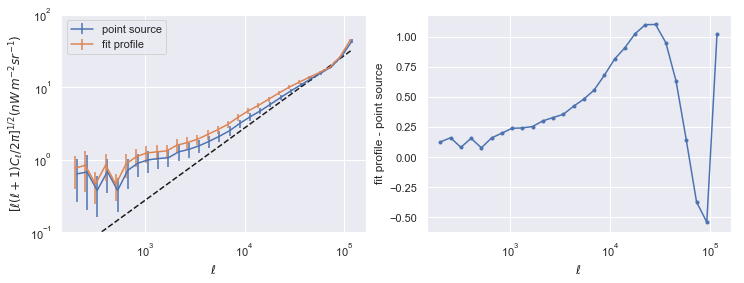

In [24]:
Dls = np.sqrt(Cls*l*(l+1)/2/np.pi/bl)
Dlm = np.sqrt(Clm*l*(l+1)/2/np.pi/bl)
Dlserr = np.sqrt(Clserr*l*(l+1)/2/np.pi/bl)
Dlmerr = np.sqrt(Clserr*l*(l+1)/2/np.pi/bl)
refline = np.sqrt(l*(l+1))
refline /= refline[-4]
refline *= np.sqrt(Cls*l*(l+1)/2/np.pi/bl)[-4]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].errorbar(l*1.02, Dls, Dlserr, label='point source')
ax[0].errorbar(l*0.98, Dlm, Dlmerr, label='fit profile')
ax[0].plot(l, refline, 'k--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim([1e-1,1e2])
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$[ \ell(\ell+1)C_\ell/2\pi ]^{1/2}( nW\,m^{-2} sr^{-1})$')
ax[0].legend()

ax[1].semilogx(l, Dlm - Dls, '.-')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_ylabel('fit profile - point source')
plt.savefig('plots/TM%d/excess_power_spec.png'%inst, dpi = 150, bbox_inches='tight')